# Install dependencies

In [ ]:
!pip install -U pybullet
!pip install -U tf-agents[reverb]
!pip install -U gym==0.23.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 21 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.2 MB/s 
     |████████████████████████████████| 18.3 MB 119 kB/s 
     |████████████████████████████████| 6.5 MB 17.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 1.6 MB 49.4 MB/s 
     |████████████████████████████████| 438 kB 75.3 MB/s 
     |████████████████████████████████| 5.8 MB 53.1 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-est

In [ ]:
import gym
import random
import PIL.Image
import pybullet_envs
import pybullet_envs.bullet as bul
from tf_agents.environments import suite_pybullet
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam
from collections import deque

current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet


# Display Environment

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


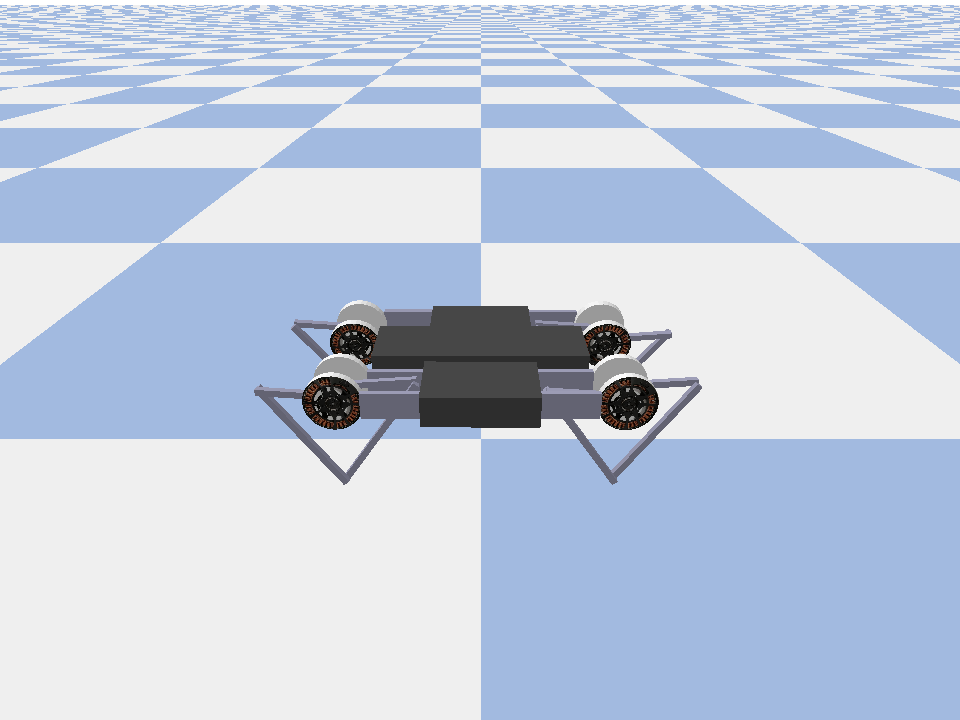

In [ ]:
env_name = "MinitaurBulletEnv-v0"

env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

# Ultility 

In [ ]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high

        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)

        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high

        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)

        return action

# Initialize ReplayBuffer, Actor, Critic Network

## Replay Buffer

In [ ]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    experience = (state, action, np.array([reward]), next_state, done)
    self.buffer.append(experience)

  def sample(self, batch_size):
    state_batch = []
    action_batch = []
    reward_batch = []
    next_state_batch = []
    done_batch = []

    batch = random.sample(self.buffer, batch_size)

    for experience in batch:
      state, action, reward, next_state, done = experience
      state_batch.append(state)
      action_batch.append(action)
      reward_batch.append(reward)
      next_state_batch.append(next_state)
      done_batch.append(done)

    return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
    return len(self.buffer)

## Soft Q Network as Critic

In [ ]:
## Act as Critic
class QNetwork(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_dim=256, init_w=3e-3):
    super(QNetwork, self).__init__()
    self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, 1)

    self.linear3.weight.data.uniform_(-init_w, init_w)
    self.linear3.bias.data.uniform_(-init_w, init_w)

  def forward(self, state, action):
    x = torch.cat([state, action], 1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

## Policy - Actor Network

In [ ]:
## Act as Actor
class PolicyNetwork(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_dim=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
    super(PolicyNetwork, self).__init__()
    self.log_std_min = log_std_min
    self.log_std_max = log_std_max

    self.linear1 = nn.Linear(num_inputs, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)

    self.mean_linear = nn.Linear(hidden_dim, num_actions)
    self.mean_linear.weight.data.uniform_(-init_w, init_w)
    self.mean_linear.bias.data.uniform_(-init_w, init_w)

    self.log_std_linear = nn.Linear(hidden_dim, num_actions)
    self.log_std_linear.weight.data.uniform_(-init_w, init_w)
    self.log_std_linear.bias.data.uniform_(-init_w, init_w)

    self.action_scale = torch.tensor(1.)
    self.action_bias = torch.tensor(0.)

  def forward(self, state):
    x = F.relu(self.linear1(state))
    x = F.relu(self.linear2(x))

    mean = self.mean_linear(x)
    log_std = self.log_std_linear(x)
    log_std = torch.clamp(log_std, min=self.log_std_min, max=self.log_std_max)

    return mean, log_std

  def sample(self, state, epsilon=1e-6):
    mean, log_std = self.forward(state)
    std = log_std.exp()

    normal = Normal(mean, std)
    z = normal.rsample()            # Reparameterization (mean + std * N(0,1))
    action = torch.tanh(z)
    action = action * self.action_scale + self.action_bias

    # Enforcing action bound
    log_pi = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
    log_pi = log_pi.sum(1, keepdim=True)
    mean = torch.tanh(mean) * self.action_scale + self.action_bias

    return action, log_pi, mean

    def to(self, device):
      self.action_scale = self.action_scale.to(device)
      self.action_bias = self.action_bias.to(device)
      return super(PolicyNetwork, self).to(device)

## Initialize SAC Agent

In [ ]:
class SACAgent:
  def __init__(self, env, gamma, tau, alpha, q_lr, policy_lr, a_lr, delay_step, noise_std, noise_bound, buffer_maxlen):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.env = env
    self.action_range = [env.action_space.low, env.action_space.high]

    # Hyperparameter
    self.gamma = gamma    ## Discount rate
    self.tau = tau      
    self.update_step = 0
    self.delay_step = delay_step

    self.noise_std = noise_std
    self.noise_bound = noise_bound

    # Init network
    ## Critic Net
    self.q_net1 = QNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
    self.q_net2 = QNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)

    ## Actor Net
    self.policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)

    ## Target Net
    self.target_net1 = QNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
    self.target_net2 = QNetwork(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)

    # Copy params to target
    for target_param, param in zip(self.target_net1.parameters(), self.q_net1.parameters()):
      target_param.data.copy_(param.data)

    for target_param, param in zip(self.target_net2.parameters(), self.q_net2.parameters()):
      target_param.data.copy_(param.data)

    # Init optimizers
    self.q1_optimizer = Adam(self.q_net1.parameters(), lr=q_lr)
    self.q2_optimizer = Adam(self.q_net2.parameters(), lr=q_lr)
    self.policy_optimizer = Adam(self.policy_net.parameters(), lr=policy_lr)

    # Entropy
    self.alpha = alpha    ## Tempature param
    self.target_entropy = -torch.prod(torch.Tensor(self.env.action_space.shape).to(self.device)).item()
    self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
    self.alpha_optim = Adam([self.log_alpha], lr=a_lr)

    # ReplayBuffer
    self.replay_buffer = ReplayBuffer(buffer_maxlen)

  def rescale_action(self, action):
    return action * (self.action_range[1] - self.action_range[0]) / 2.0 + (self.action_range[1] + self.action_range[0]) / 2.0

  # From TD3  
  def generate_action_space_noise(self, action_batch):
    noise = torch.normal(torch.zeros(action_batch.size()), self.noise_std).clamp(-self.noise_bound, self.noise_bound).to(self.device)
    return noise

  def get_action(self, state):
    state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
    mean, log_std = self.policy_net.forward(state)
    std = log_std.exp()

    normal = Normal(mean, std)
    z = normal.sample()
    action = torch.tanh(z)
    action = action.cpu().detach().squeeze(0).numpy()

    return self.rescale_action(action)

  def update(self, batch_size):
    states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

    states = torch.FloatTensor(states).to(self.device)
    actions = torch.FloatTensor(actions).to(self.device)
    rewards = torch.FloatTensor(rewards).to(self.device)
    next_states = torch.FloatTensor(next_states).to(self.device)
    dones = torch.FloatTensor(dones).to(self.device)
    dones = dones.view(dones.size(0), -1)

    action_space_noise = self.generate_action_space_noise(actions)

    next_actions, next_log_pi, _ = self.policy_net.sample(next_states)
    next_actions = next_actions + action_space_noise
    next_q1 = self.target_net1(next_states, next_actions)
    next_q2 = self.target_net2(next_states, next_actions)
    next_q_target = torch.min(next_q1, next_q2) - self.alpha * next_log_pi
    expected_q = rewards + (1 - dones) * self.gamma * next_q_target

    # Calculate q loss
    curr_q1 = self.q_net1.forward(states, actions)
    curr_q2 = self.q_net2.forward(states, actions)
    q1_loss = F.mse_loss(curr_q1, expected_q.detach())
    q2_loss = F.mse_loss(curr_q2, expected_q.detach())

    # Update Q networks
    self.q1_optimizer.zero_grad()
    q1_loss.backward()
    self.q1_optimizer.step()

    self.q2_optimizer.zero_grad()
    q2_loss.backward()
    self.q2_optimizer.step()

    # Delayed update for policy network and target q network
    new_actions, log_pi, _ = self.policy_net.sample(states)
    if self.update_step % self.delay_step == 0:
      min_q = torch.min(self.q_net1.forward(states, new_actions), 
                        self.q_net2.forward(states, new_actions))
      policy_loss = (self.alpha * log_pi - min_q).mean()
      
      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      self.policy_optimizer.step()

      # Target network
      for target_param, param in zip(self.target_net1.parameters(), self.q_net1.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

      for target_param, param in zip(self.target_net2.parameters(), self.q_net2.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    # Update tempature
    alpha_loss = (self.log_alpha * (-log_pi - self.target_entropy).detach()).mean()

    self.alpha_optim.zero_grad()
    alpha_loss.backward()
    self.alpha_optim.step()
    self.alpha = self.log_alpha.exp()

    self.update_step += 1

# Training

In [ ]:
def sac_train(env, agent, max_episode, max_step, batch_size):
  episode_rewards = []
  update_step = 0

  for episode in range(max_episode):
    state = env.reset()
    episode_reward = 0

    for step in range(max_step):
      action = agent.get_action(state)
      next_state, reward, done, _ = env.step(action)
      agent.replay_buffer.push(state, action, reward, next_state, done)
      episode_reward += reward

      if len(agent.replay_buffer) > batch_size:
        agent.update(batch_size)
        update_step += 1

      if done or step == max_step - 1:
        episode_rewards.append(episode_reward)
        break
      
      state = next_state
    if episode % 10 == 0:
      print("Episode " + str(episode) + ": " + str(episode_reward))

  return episode_rewards

In [ ]:
env = gym.make(env_name)

gamma = 0.99
tau = 0.01
alpha = 0.2
a_lr = 3e-4
q_lr = 3e-4
p_lr = 3e-4
noise_std = 0.2
noise_bound = 0.5
delay_step = 2
buffer_maxlen = 1000000

max_episode = 3000

agent = SACAgent(env, gamma, tau, alpha, q_lr, p_lr, a_lr, delay_step, noise_std, noise_bound, buffer_maxlen)

episode_rewards = sac_train(env, agent, max_episode, 500, 64)

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Episode 0: -0.9924712654624859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Episode 10: -0.062379814186537146
Episode 20: -0.8043489461414587
Episode 30: 0.12199832867808583
Episode 40: 0.219951149758501
Episode 50: -0.2332786331644987
Episode 60: -0.05195807266135718
Episode 70: 0.3928845176817566
Episode 80: 0.16407386402524737
Episode 90: -0.352940874389412
Episode 100: 0.05163966639077152
Episode 110: -0.28299144582814656
Episode 120: -0.14994797117083897
Episode 130: -0.6242747722852816
Episode 140: -0.11739987631268185
Episode 150: 0.03177220306660872
Episode 160: -0.7568682822047282
Episode 170: 0.14755844550623223
Episode 180: -0.13757547075967386
Episode 190: -0.4690335091618462
Episode 200: -0.15461544536041202
Episode 210: -0.09703201043531627
Episode 220: -1.0993368084459194
Episode 230: -0.19990402294681156
Episode 240: -0.797750409099499
Episode 250: -0.06436215721517351
Episode 260: 0.12003713904200465
Episode 270: 0.025859520489072425
Episode 280: 0.06519463767424724
Episode 290: -0.08316897608286285
Episode 300: 0.026187644336605954
Episode 31

# Evaluation

In [ ]:
import matplotlib.pyplot as plt

episodes = [i for i in range(max_episode) if i % 100 == 0]

reward_per_hundred = [episode_rewards[i] for i in range(max_episode) if i % 100 == 0]

plt.figure(figsize=(10, 15))
plt.plot(episodes, reward_per_hundred)
plt.title('Reward per 100 episodes')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [ ]:
episodes = [i for i in range(max_episode)]

plt.figure(figsize=(10, 15))
plt.plot(episodes, episode_rewards)
plt.title('Reward per episode')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()